This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

In [8]:
# import libraries
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [9]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

The "data date" is 2020-05-20 00:00:00

ADF Statistic: -1.401541
p-value: 0.581537
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588


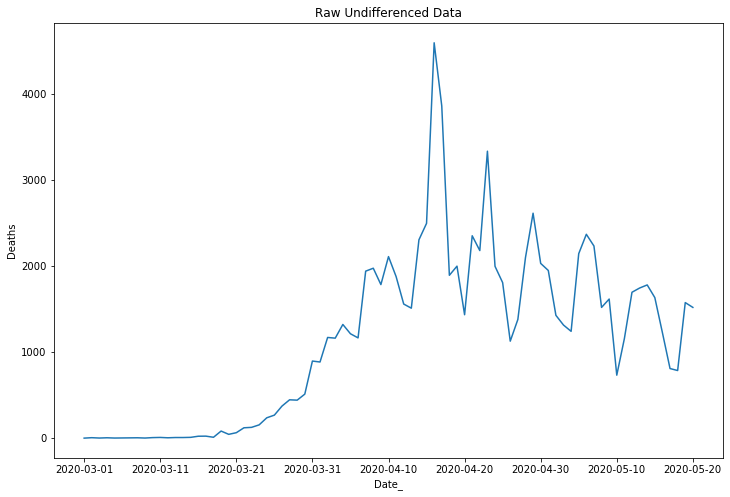

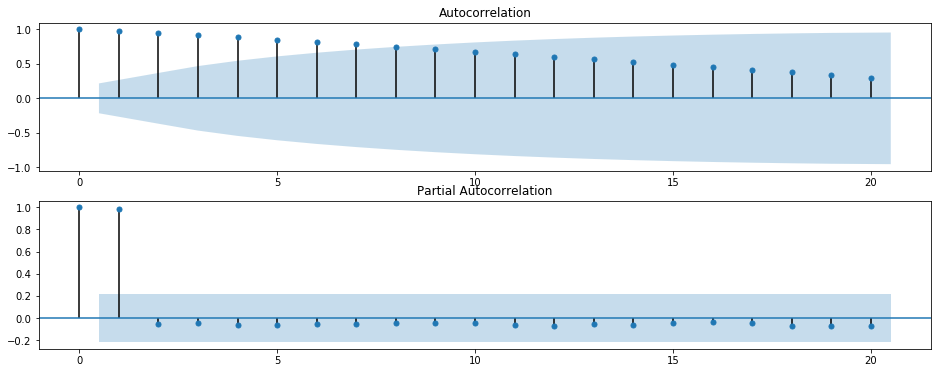

ARIMA(0, 0, 1) RMSE=32302.742
ARIMA(0, 1, 1) RMSE=1335.150
ARIMA(0, 2, 1) RMSE=709.520
ARIMA(0, 2, 2) RMSE=801.028
ARIMA(1, 0, 0) RMSE=2027.259
ARIMA(1, 1, 0) RMSE=689.163
ARIMA(1, 2, 0) RMSE=720.387
ARIMA(1, 2, 1) RMSE=742.986
ARIMA(2, 1, 0) RMSE=718.313
ARIMA(2, 2, 0) RMSE=861.685
Best ARIMA(1, 1, 0) RMSE=689.163
RMSE: 689.163
                 0
count    41.000000
mean     80.730139
std     692.920858
min   -1910.415504
25%    -310.970898
50%      28.416831
75%     352.905977
max    2117.744661


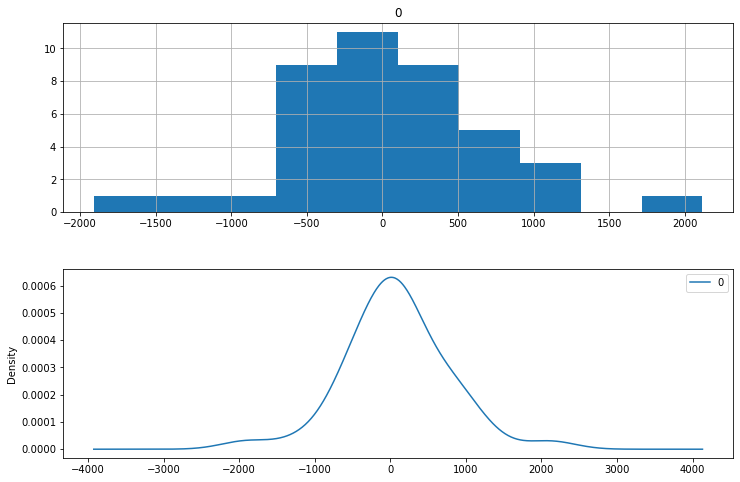


bias saved in arg_dict["bias"] for subsequent run is: 80.73013936143794 

RMSE: 684.418
                  0
count  4.100000e+01
mean   2.129549e-12
std    6.929209e+02
min   -1.991146e+03
25%   -3.917010e+02
50%   -5.231331e+01
75%    2.721758e+02
max    2.037015e+03


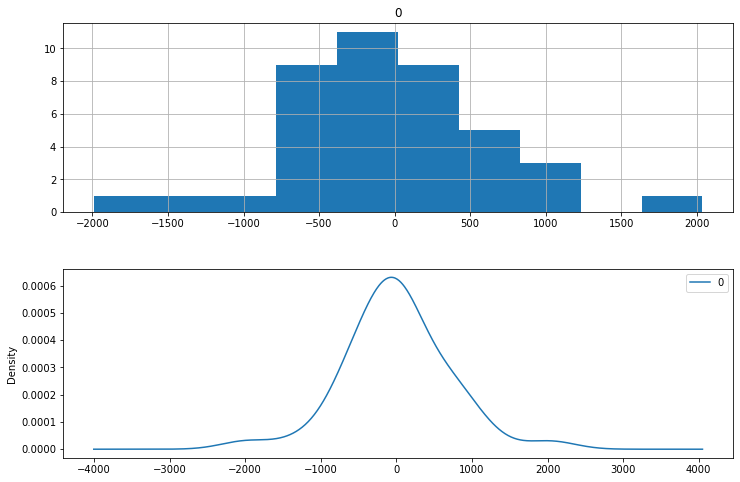


bias saved in arg_dict["bias"] for subsequent run is: 2.129548570004905e-12 



In [10]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'bias': bias})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rerun summarize, as bias adjusted
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 93,480


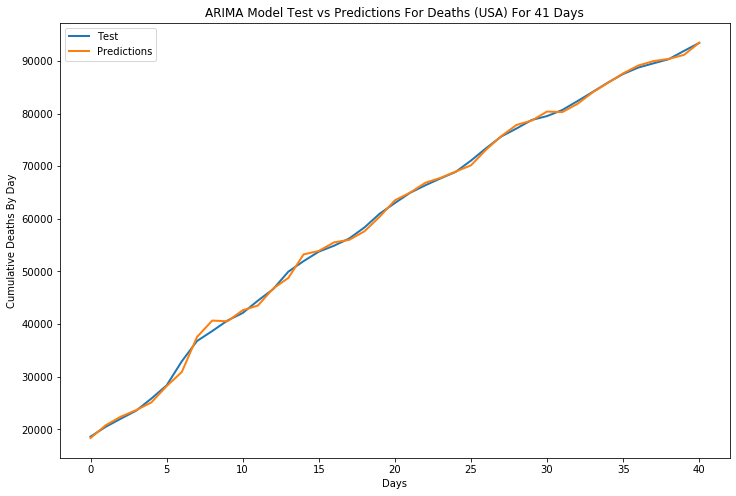

In [11]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

The USA prediction is for 938,832 cumulative Deaths to occur by 2020-12-31 00:00:00


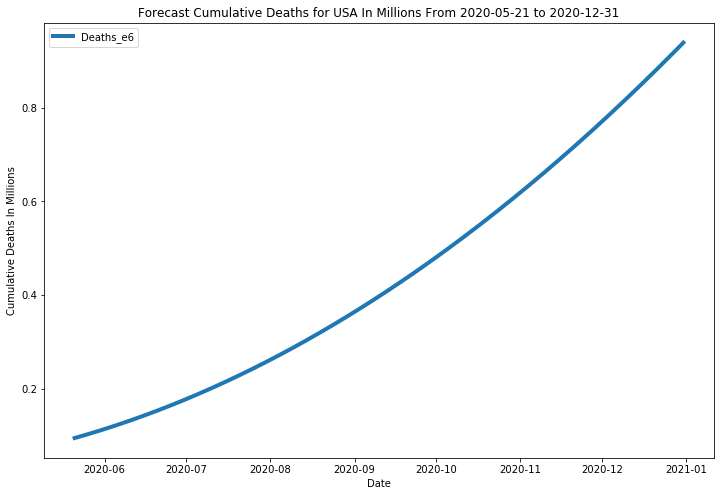

In [12]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to flatten the curve by the date indicated. We truncate the prediction at that point.

In [13]:
df.tail()

,Deaths
Date_,
2020-05-16,88754.0
2020-05-17,89562.0
2020-05-18,90347.0
2020-05-19,91921.0
2020-05-20,93439.0


In [14]:
forecast_df.head()

,Deaths,Deaths_e6
Date_,,
2020-05-21,95062.0,0.095062
2020-05-22,96704.0,0.096704
2020-05-23,98366.0,0.098366
2020-05-24,100046.0,0.100046
2020-05-25,101746.0,0.101746
